Available columns: Index(['image_path', 'label'], dtype='object')


C:\Users\Dell\AppData\Local\Temp\ipykernel_6684\3463683922.py:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets).to(device)


              precision    recall  f1-score   support

           0       0.95      0.87      0.91       411
           1       0.98      0.99      0.99      3135

    accuracy                           0.98      3546
   macro avg       0.97      0.93      0.95      3546
weighted avg       0.98      0.98      0.98      3546



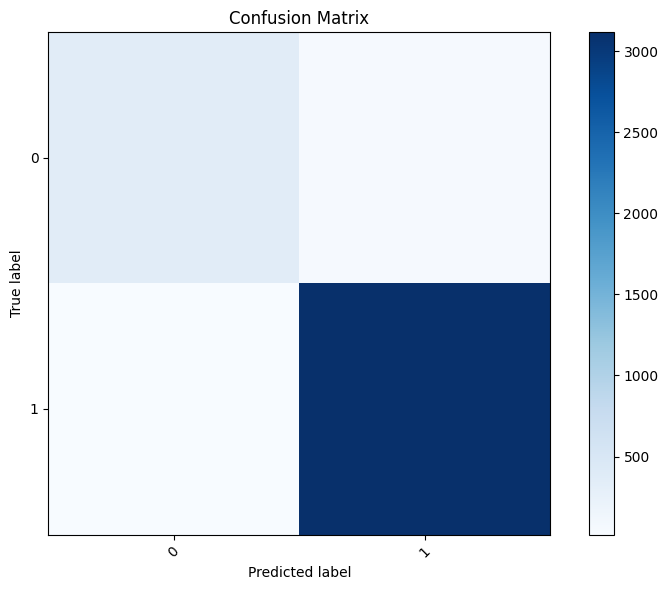

IndexError: index 1 is out of bounds for axis 1 with size 1

In [3]:
import os
import torch
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
from transformers import AutoModelForImageClassification, ViTImageProcessor
from torch.utils.data import DataLoader
from torchvision import transforms
from sklearn.preprocessing import label_binarize

# Paths and configurations
model_dir = "./models/helmet_vit/"
train_csv = "./train_labels.csv"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model and preprocessor
model = AutoModelForImageClassification.from_pretrained(model_dir, local_files_only=True)
processor = ViTImageProcessor.from_pretrained(model_dir)
model.to(device)
model.eval()

# Load dataset
df = pd.read_csv(train_csv)
print("Available columns:", df.columns)

# Extract image paths and labels
image_paths = df['image_path'].tolist()
labels = df['label'].tolist()
label_classes = sorted(set(labels))
label_to_idx = {label: idx for idx, label in enumerate(label_classes)}
idx_to_label = {idx: label for label, idx in label_to_idx.items()}

# Define dataset class
class HelmetDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, labels, transform):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        from PIL import Image
        image = Image.open(self.image_paths[idx]).convert("RGB")
        image = self.transform(image)
        label = self.labels[idx]
        return image, label_to_idx[label]

# Transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Create dataset and DataLoader
dataset = HelmetDataset(image_paths, labels, transform)
batch_size = 16
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Evaluation
all_preds = []
all_labels = []

with torch.no_grad():
    for images, targets in dataloader:
        images = images.to(device)
        targets = torch.tensor(targets).to(device)
        outputs = model(images).logits
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(targets.cpu().numpy())

# Convert predictions and labels back to class names
all_preds = pd.Series(all_preds).map(idx_to_label).values
all_labels = pd.Series(all_labels).map(idx_to_label).values

# Classification report
print(classification_report(all_labels, all_preds))

# Visualizations
# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds, labels=label_classes)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
plt.xticks(range(len(label_classes)), label_classes, rotation=45)
plt.yticks(range(len(label_classes)), label_classes)
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.tight_layout()
plt.show()

# ROC Curve
if len(label_classes) > 2:
    y_true_bin = label_binarize([label_to_idx[label] for label in all_labels], classes=range(len(label_classes)))
    y_pred_bin = label_binarize([label_to_idx[label] for label in all_preds], classes=range(len(label_classes)))
    for i, class_name in enumerate(label_classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_bin[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"Class {class_name} (AUC = {roc_auc:.2f})")
else:
    y_true_bin = label_binarize([label_to_idx[label] for label in all_labels], classes=range(len(label_classes)))
    y_pred_bin = [label_to_idx[label] for label in all_preds]
    fpr, tpr, _ = roc_curve(y_true_bin[:, 1], y_pred_bin)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")

plt.plot([0, 1], [0, 1], "k--")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.tight_layout()
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_true_bin[:, 1], y_pred_bin)
plt.plot(recall, precision, label="Precision-Recall Curve")
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.tight_layout()
plt.show()

In [ ]:
import os
import torch
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
from transformers import AutoModelForImageClassification, ViTImageProcessor
from torch.utils.data import DataLoader
from torchvision import transforms
from sklearn.preprocessing import label_binarize

# Paths and configurations
model_dir = "./models/helmet_vit/"
train_csv = "./train_labels.csv"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model and preprocessor
model = AutoModelForImageClassification.from_pretrained(model_dir, local_files_only=True)
processor = ViTImageProcessor.from_pretrained(model_dir)
model.to(device)
model.eval()

# Load dataset
df = pd.read_csv(train_csv)
print("Available columns:", df.columns)

# Extract image paths and labels
image_paths = df['image_path'].tolist()
labels = df['label'].tolist()
label_classes = sorted(set(labels))
label_to_idx = {label: idx for idx, label in enumerate(label_classes)}
idx_to_label = {idx: label for label, idx in label_to_idx.items()}

# Define dataset class
class HelmetDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, labels, transform):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        from PIL import Image
        image = Image.open(self.image_paths[idx]).convert("RGB")
        image = self.transform(image)
        label = self.labels[idx]
        return image, label_to_idx[label]

# Transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Create dataset and DataLoader
dataset = HelmetDataset(image_paths, labels, transform)
batch_size = 16
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Evaluation
all_preds = []
all_labels = []

with torch.no_grad():
    for images, targets in dataloader:
        images = images.to(device)
        targets = torch.tensor(targets).to(device)
        outputs = model(images).logits
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(targets.cpu().numpy())

# Convert predictions and labels back to class names
all_preds = pd.Series(all_preds).map(idx_to_label).values
all_labels = pd.Series(all_labels).map(idx_to_label).values

# Classification report
print(classification_report(all_labels, all_preds))

# Visualizations
# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds, labels=label_classes)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
plt.xticks(range(len(label_classes)), label_classes, rotation=45)
plt.yticks(range(len(label_classes)), label_classes)
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.tight_layout()
plt.show()

# ROC Curve
if len(label_classes) > 2:
    y_true_bin = label_binarize([label_to_idx[label] for label in all_labels], classes=range(len(label_classes)))
    y_pred_bin = label_binarize([label_to_idx[label] for label in all_preds], classes=range(len(label_classes)))
    for i, class_name in enumerate(label_classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_bin[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"Class {class_name} (AUC = {roc_auc:.2f})")
else:
    # Binary classification: Use only the positive class (index 1)
    y_true_bin = label_binarize([label_to_idx[label] for label in all_labels], classes=[0, 1])
    y_pred_bin = label_binarize([label_to_idx[label] for label in all_preds], classes=[0, 1])
    fpr, tpr, _ = roc_curve(y_true_bin[:, 1], y_pred_bin[:, 1])  # Index 1 for positive class
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")

plt.plot([0, 1], [0, 1], "k--")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.tight_layout()
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_true_bin[:, 1], y_pred_bin[:, 1])  # Index 1 for positive class
plt.plot(recall, precision, label="Precision-Recall Curve")
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.tight_layout()
plt.show()


Available columns: Index(['image_path', 'label'], dtype='object')


C:\Users\Dell\AppData\Local\Temp\ipykernel_6684\3153592316.py:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets).to(device)


In [ ]:
import os
import torch
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
from transformers import AutoModelForImageClassification, ViTImageProcessor
from torch.utils.data import DataLoader
from torchvision import transforms
from sklearn.preprocessing import label_binarize

# Paths and configurations
model_dir = "./models/helmet_vit/"
train_csv = "./train_labels.csv"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model and preprocessor
model = AutoModelForImageClassification.from_pretrained(model_dir, local_files_only=True)
processor = ViTImageProcessor.from_pretrained(model_dir)
model.to(device)
model.eval()

# Load dataset
df = pd.read_csv(train_csv)
print("Available columns:", df.columns)

# Extract image paths and labels
image_paths = df['image_path'].tolist()
labels = df['label'].tolist()
label_classes = sorted(set(labels))
label_to_idx = {label: idx for idx, label in enumerate(label_classes)}
idx_to_label = {idx: label for label, idx in label_to_idx.items()}

# Define dataset class
class HelmetDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, labels, transform):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        from PIL import Image
        image = Image.open(self.image_paths[idx]).convert("RGB")
        image = self.transform(image)
        label = self.labels[idx]
        return image, label_to_idx[label]

# Transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Create dataset and DataLoader
dataset = HelmetDataset(image_paths, labels, transform)
batch_size = 16
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Evaluation
all_preds = []
all_labels = []

with torch.no_grad():
    for images, targets in dataloader:
        images = images.to(device)
        targets = torch.tensor(targets).to(device)
        outputs = model(images).logits
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(targets.cpu().numpy())

# Convert predictions and labels back to class names
all_preds = pd.Series(all_preds).map(idx_to_label).values
all_labels = pd.Series(all_labels).map(idx_to_label).values

# Classification report
print(classification_report(all_labels, all_preds))

# Visualizations
# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds, labels=label_classes)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
plt.xticks(range(len(label_classes)), label_classes, rotation=45)
plt.yticks(range(len(label_classes)), label_classes)
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.tight_layout()
plt.show()

# Prepare for ROC and Precision-Recall Curve
y_true_bin = label_binarize([label_to_idx[label] for label in all_labels], classes=range(len(label_classes)))
y_pred_bin = label_binarize([label_to_idx[label] for label in all_preds], classes=range(len(label_classes)))

# ROC Curve
if len(set(y_true_bin.flatten())) == 1 or len(set(y_pred_bin.flatten())) == 1:
    print("Warning: Only one class present in the predictions or true labels. ROC curve cannot be computed.")
else:
    if len(label_classes) > 2:
        for i, class_name in enumerate(label_classes):
            fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_bin[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f"Class {class_name} (AUC = {roc_auc:.2f})")
    else:
        fpr, tpr, _ = roc_curve(y_true_bin[:, 1], y_pred_bin[:, 1])  # Index 1 for positive class
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")

plt.plot([0, 1], [0, 1], "k--")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.tight_layout()
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_true_bin[:, 1], y_pred_bin[:, 1])  # Index 1 for positive class
plt.plot(recall, precision, label="Precision-Recall Curve")
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.tight_layout()
plt.show()


In [ ]:
import os
import torch
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
from transformers import AutoModelForImageClassification, ViTImageProcessor
from torch.utils.data import DataLoader
from torchvision import transforms
from sklearn.preprocessing import label_binarize

# Paths and configurations
model_dir = "./models/helmet_vit/"
train_csv = "./train_labels.csv"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model and preprocessor
model = AutoModelForImageClassification.from_pretrained(model_dir, local_files_only=True)
processor = ViTImageProcessor.from_pretrained(model_dir)
model.to(device)
model.eval()

# Load dataset
df = pd.read_csv(train_csv)
print("Available columns:", df.columns)

# Extract image paths and labels
image_paths = df['image_path'].tolist()
labels = df['label'].tolist()
label_classes = sorted(set(labels))
label_to_idx = {label: idx for idx, label in enumerate(label_classes)}
idx_to_label = {idx: label for label, idx in label_to_idx.items()}

# Define dataset class
class HelmetDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, labels, transform):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        from PIL import Image
        image = Image.open(self.image_paths[idx]).convert("RGB")
        image = self.transform(image)
        label = self.labels[idx]
        return image, label_to_idx[label]

# Transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Create dataset and DataLoader
dataset = HelmetDataset(image_paths, labels, transform)
batch_size = 16
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Evaluation
all_preds = []
all_labels = []

with torch.no_grad():
    for images, targets in dataloader:
        images = images.to(device)
        targets = torch.tensor(targets).to(device)
        outputs = model(images).logits
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(targets.cpu().numpy())

# Convert predictions and labels back to class names
all_preds = pd.Series(all_preds).map(idx_to_label).values
all_labels = pd.Series(all_labels).map(idx_to_label).values

# Classification report
report = classification_report(all_labels, all_preds, target_names=label_classes, output_dict=True)
print(classification_report(all_labels, all_preds))

# Visualizations
# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds, labels=label_classes)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
plt.xticks(range(len(label_classes)), label_classes, rotation=45)
plt.yticks(range(len(label_classes)), label_classes)
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.tight_layout()
plt.show()

# F1 Score, Precision, Recall visualization
f1_scores = [report[cls]['f1-score'] for cls in label_classes]
precisions = [report[cls]['precision'] for cls in label_classes]
recalls = [report[cls]['recall'] for cls in label_classes]

x = range(len(label_classes))

# Plot F1 Scores
plt.figure(figsize=(10, 6))
plt.bar(x, f1_scores, color='skyblue')
plt.xticks(x, label_classes, rotation=45)
plt.title("F1 Scores for Each Class")
plt.xlabel("Class")
plt.ylabel("F1 Score")
plt.tight_layout()
plt.show()

# Plot Precision
plt.figure(figsize=(10, 6))
plt.bar(x, precisions, color='lightgreen')
plt.xticks(x, label_classes, rotation=45)
plt.title("Precision for Each Class")
plt.xlabel("Class")
plt.ylabel("Precision")
plt.tight_layout()
plt.show()

# Plot Recall
plt.figure(figsize=(10, 6))
plt.bar(x, recalls, color='lightcoral')
plt.xticks(x, label_classes, rotation=45)
plt.title("Recall for Each Class")
plt.xlabel("Class")
plt.ylabel("Recall")
plt.tight_layout()
plt.show()
